In [16]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Importing park properties
#https://data.cityofnewyork.us/api/geospatial/rjaj-zgq7?method=export&format=GeoJSON
parks = gp.read_file('../data/external/parks.geojson')
parks = parks.to_crs({'init' :'epsg:4326'})
parks.head()

,acres,address,borough,communityb,councildis,geometry,gispropnum,location,nys_assemb,nys_senate,signname,typecatego,us_congres,waterfront,zipcode
0,20.34,40-50 VERNON BOULEVARD,Q,"401, 402",26,(POLYGON ((-73.94806058617907 40.7558921243117...,Q104,"Queensboro Bridge, 41 Rd., 40 Ave. bet. The Ea...",37,12,Queensbridge Park,Community Park,12,Yes,11101
1,6.1,200 CITY ISLAND AV,X,210,13,(POLYGON ((-73.78243845176827 40.8440889832096...,X253,City Island Ave bet. Centre St. and Winter St.,82,34,Ambrosini Field,Recreation Field/Courts,14,Yes,10464
2,0.159,11528 Ocean Promenade,Q,414,32,(POLYGON ((-73.83638471337602 40.5780595390407...,Q494,"Beach 116 St., Ocean Promenade",23,15,Flight 587 Memorial Park,Triangle/Plaza,5,Yes,11694
3,0.44,1086 EAST 180 STREET,X,206,15,(POLYGON ((-73.87623969625949 40.8419878695552...,X245,E 180 St bet. the Bronx River and Devoe Av,87,33,River Garden,Garden,15,Yes,10460
4,4.893,31-30 VERNON BOULEVARD,Q,401,26,(POLYGON ((-73.93623823248316 40.7692821829763...,Q465,Vernon Blvd. bet. Broadway and 30 Dr.,37,12,Socrates Sculpture Park,Neighborhood Park,12,Yes,11106


In [3]:
parks.drop([u'acres',    u'address',    u'borough', u'communityb',
       u'councildis',   u'gispropnum', 
       u'nys_assemb', u'nys_senate',    u'typecatego',
       u'us_congres', u'waterfront',    u'zipcode'], axis = 1, inplace = True)

In [4]:
# Importing CitiBike Data
stations = pd.read_csv('../data/processed/stations.csv')
stations = stations.dropna()
stations.drop(['Station_Name'], axis= 1, inplace=True)
stations.head()

,Station_id,Location,Latitude,Longitude
0,72,W 52 St & 11 Ave,40.767272,-73.993929
1,79,Franklin St & W Broadway,40.719116,-74.006667
2,82,St James Pl & Pearl St,40.711174,-74.000165
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
4,116,W 17 St & 8 Ave,40.741776,-74.001497


In [5]:
#Creating a buffer of 0.0005
geometry = gp.GeoSeries([Point(xy) for xy in zip(stations.Longitude, stations.Latitude)])
geometry = geometry.buffer(.0005)  # Using buffer of 0.0005
geo_stations = gp.GeoDataFrame(stations, geometry=geometry)
geo_stations.crs = {'init' :'epsg:4326'}
geo_stations.to_file('../data/interim/geo_stations')
geo_stations.head()

,Station_id,Location,Latitude,Longitude,geometry
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431..."
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74...."
2,82,St James Pl & Pearl St,40.711174,-74.000165,"POLYGON ((-73.99966544999999 40.71117416, -73...."
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,"POLYGON ((-73.97582328 40.68382604, -73.975825..."
4,116,W 17 St & 8 Ave,40.741776,-74.001497,"POLYGON ((-74.00099745999999 40.74177603, -74...."


In [6]:
#Merging datasets
bike_park = gp.sjoin(geo_stations, parks, how = 'inner', op = 'intersects')
bike_park.head()

,Station_id,Location,Latitude,Longitude,geometry,index_right,location,signname
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431...",197,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",De Witt Clinton Park
2,82,St James Pl & Pearl St,40.711174,-74.000165,"POLYGON ((-73.99966544999999 40.71117416, -73....",1339,"Pearl St., Madison St. and St James Pl.",James Madison Plaza
4,116,W 17 St & 8 Ave,40.741776,-74.001497,"POLYGON ((-74.00099745999999 40.74177603, -74....",131,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground
655,3428,8 Ave & W 16 St,40.740983,-74.001702,"POLYGON ((-74.00120200000001 40.740983, -74.00...",131,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground
5,119,Park Ave & St Edwards St,40.696089,-73.978034,"POLYGON ((-73.97753415 40.69608941, -73.977536...",53,"Nassau St., Park Ave., bet. Navy St. and N. El...",Commodore Barry Park


In [7]:
#Grouping data
bike_park = bike_park.groupby(['Station_id' , 'Location', 'location', 'signname']).count()
bike_park.head()

,,,,Latitude,Longitude,geometry,index_right
Station_id,Location,location,signname,,,,
72,W 52 St & 11 Ave,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",De Witt Clinton Park,1,1,1,1
82,St James Pl & Pearl St,"Pearl St., Madison St. and St James Pl.",James Madison Plaza,1,1,1,1
116,W 17 St & 8 Ave,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground,1,1,1,1
119,Park Ave & St Edwards St,"Nassau St., Park Ave., bet. Navy St. and N. Elliot Pl.",Commodore Barry Park,1,1,1,1
128,MacDougal St & Prince St,Ave. Of Americas bet. Prince St. and Spring St.,Father Fagan Park,1,1,1,1


In [8]:
bike_park.drop(['Latitude', 'Longitude', 'geometry', 'index_right'], axis = 1, inplace=True)
bike_park.head()

,,,
Station_id,Location,location,signname
72,W 52 St & 11 Ave,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",De Witt Clinton Park
82,St James Pl & Pearl St,"Pearl St., Madison St. and St James Pl.",James Madison Plaza
116,W 17 St & 8 Ave,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground
119,Park Ave & St Edwards St,"Nassau St., Park Ave., bet. Navy St. and N. Elliot Pl.",Commodore Barry Park
128,MacDougal St & Prince St,Ave. Of Americas bet. Prince St. and Spring St.,Father Fagan Park


In [9]:
# Creating index 1 for all CitiBike stations in proximity to subway entrances
bike_park = bike_park.reset_index()
bike_park.rename(columns={'Location' : 'citibike_location', 'location' : 'park_location'}, inplace=True)
bike_park['park'] = 1
bike_park.head()

,Station_id,citibike_location,park_location,signname,park
0,72,W 52 St & 11 Ave,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",De Witt Clinton Park,1
1,82,St James Pl & Pearl St,"Pearl St., Madison St. and St James Pl.",James Madison Plaza,1
2,116,W 17 St & 8 Ave,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground,1
3,119,Park Ave & St Edwards St,"Nassau St., Park Ave., bet. Navy St. and N. El...",Commodore Barry Park,1
4,128,MacDougal St & Prince St,Ave. Of Americas bet. Prince St. and Spring St.,Father Fagan Park,1


In [11]:
# Save to CSV
bike_park.to_csv('../data/processed/parks.csv')

In [ ]:
# exploratory analysis

In [10]:
bike_park.shape

(231, 5)

In [11]:
#Merging datasets, keeping all the stations
bike0_park = gp.sjoin(geo_stations, parks, how = 'left', op = 'intersects')
bike0_park.head()

,Station_id,Location,Latitude,Longitude,geometry,index_right,location,signname
0,72,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431...",197.0,"W. 52 St. To W. 54 St., 11 Ave. To 12 Ave.",De Witt Clinton Park
1,79,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74....",NaN,NaN,NaN
2,82,St James Pl & Pearl St,40.711174,-74.000165,"POLYGON ((-73.99966544999999 40.71117416, -73....",1339.0,"Pearl St., Madison St. and St James Pl.",James Madison Plaza
3,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,"POLYGON ((-73.97582328 40.68382604, -73.975825...",NaN,NaN,NaN
4,116,W 17 St & 8 Ave,40.741776,-74.001497,"POLYGON ((-74.00099745999999 40.74177603, -74....",131.0,"W. 17 St., 8 Ave. To 9 Ave.",Dr. Gertrude B. Kelly Playground


In [19]:
bike0_park.shape

(701, 8)

In [26]:
#bike0_park.crs = {'init' :'epsg:4326'}
#bike0_park.crs= {'init': 'epsg:26918'}

In [14]:
#Grouping data
bike0_park_count = bike0_park['signname'].groupby(bike0_park['Station_id']).count()
bike0_park_count[:5]

Station_id
72     1
79     0
82     1
83     0
116    1
Name: signname, dtype: int64

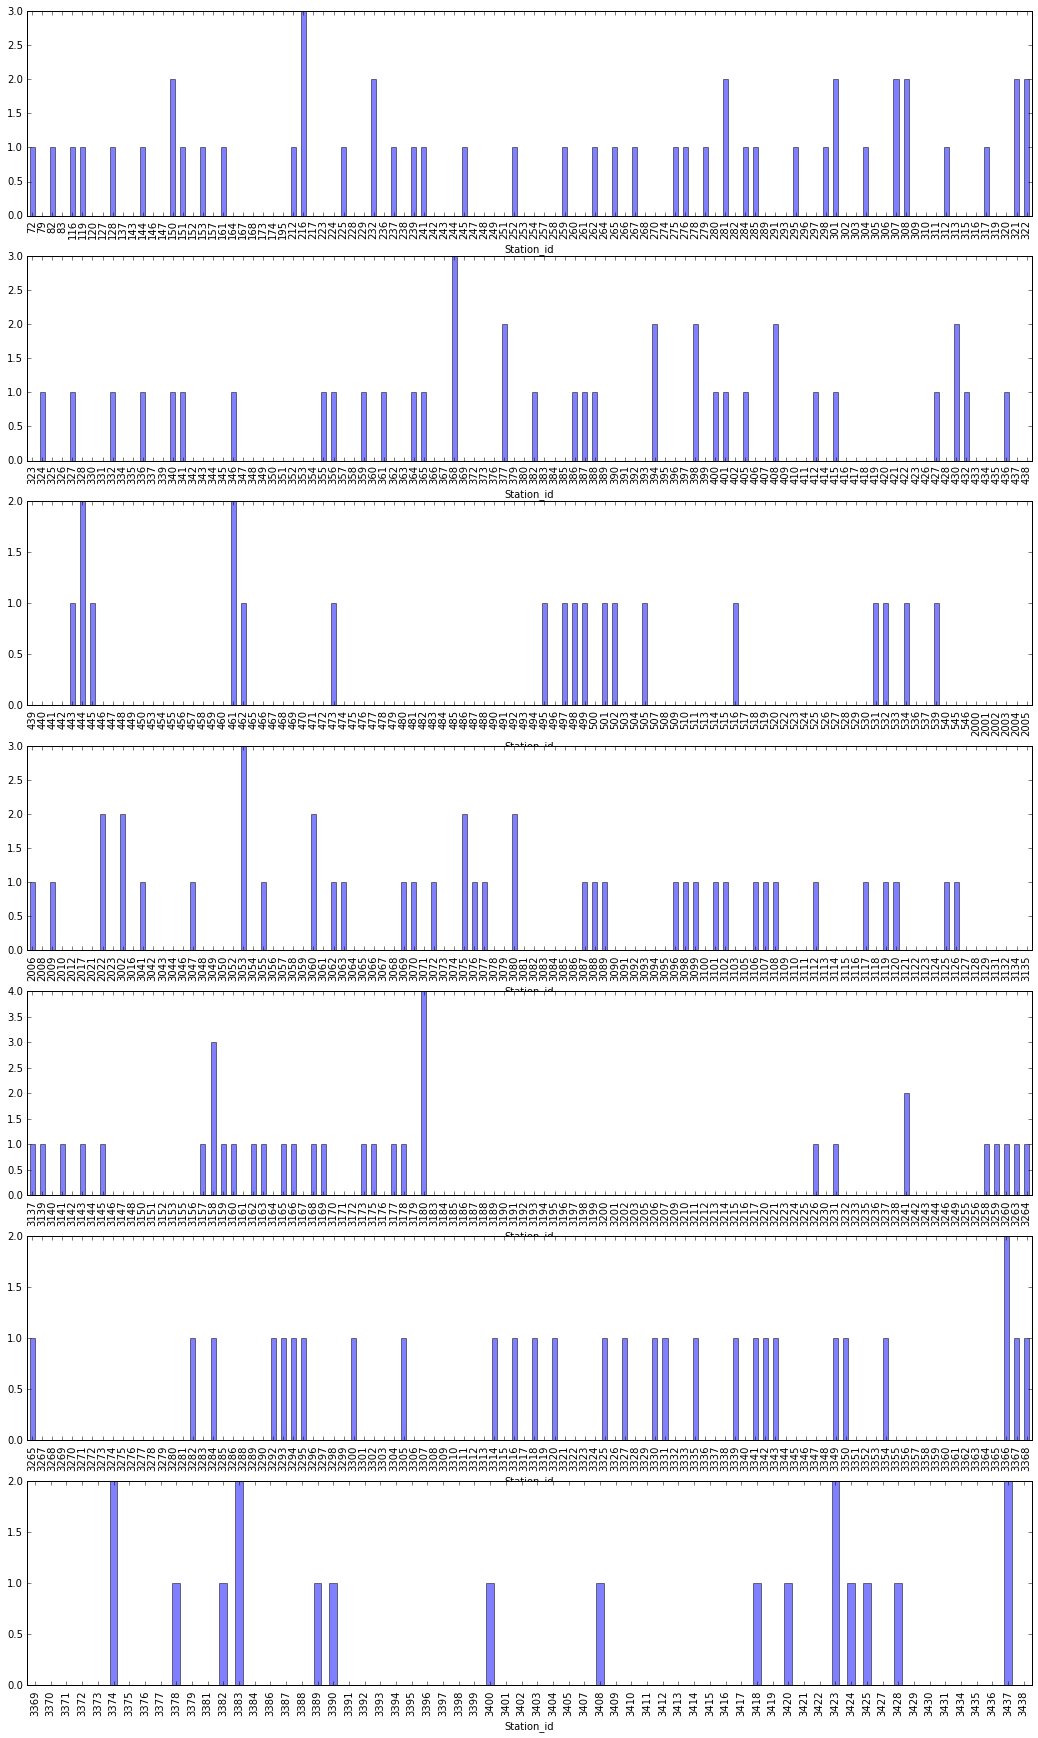

In [34]:
fig = plt.figure(figsize=(18,30))
fig.add_subplot(711)

plt.subplot(711)
bike0_park_count[:100].plot(kind="bar", alpha=0.5)
plt.subplot(712)
bike0_park_count[100:200].plot(kind="bar", alpha=0.5)
plt.subplot(713)
bike0_park_count[200:300].plot(kind="bar", alpha=0.5)
plt.subplot(714)
bike0_park_count[300:400].plot(kind="bar", alpha=0.5)
plt.subplot(715)
bike0_park_count[400:500].plot(kind="bar", alpha=0.5)
plt.subplot(716)
bike0_park_count[500:600].plot(kind="bar", alpha=0.5)
plt.subplot(717)
bike0_park_count[600:].plot(kind="bar", alpha=0.5)

In [ ]:
bike0_park_count == 1 

In [ ]:
fig2 = plt.figure(figsize=(12,6))

# not a good idea-- id are categorical

#bike0_park['Station_id'].plot.hist(by='Station_id', bins=20)